In [1]:
%matplotlib inline
import cv2
import os
import numpy as np
import glob
import matplotlib.pyplot as plt

from facetrackinglib.tensorflow.TFInference import TFInference

ftlib_dir = './facetrackinglib/tensorflow/'
face_detector = cv2.CascadeClassifier(os.path.join(ftlib_dir, 'models/haarcascade_frontalface_default.xml'))
refined_landmark_inference = TFInference(model_path = os.path.join(ftlib_dir, 
                                                                  #'models/faceoff_kao_onet_64x64x3_face_56_face_136_batch_32_random_hflip_False_reduce_lr_0.5.600-0.39-0.48.hdf5.pb'
                                                                  'models/faceoff_kao_onet_96x96x3_face_84_face_136_batch_32_random_hflip_False_reduce_lr_0.5.538-0.59-0.74.hdf5.pb',
                                                                  # '3d model'
                                                                #'models/faceoff_kao_onet_96x96x3_face_84_face_136_batch_32_random_hflip_False_reduce_lr_0.5.677-0.51-0.65.hdf5.pb', 
                                                                   # Non-3d models that performs poorly
                                                                  #'models/faceoff_kao_onet_64x64x3_face_56_face_136_batch_32_random_hflip_False_reduce_lr_0.5.464-0.26-0.26.hdf5.pb'                                                         
                                                                  #'models/faceoff_kao_onet_64x64x3_face_56_face_136_batch_32_random_hflip_False_reduce_lr_0.5.345-0.26-0.26.hdf5.pb'
                                                                  ),
                                         input_name = 'import/input_1',
                                         output_names = ['import/output_node0'])
refined_landmark_target_size = refined_landmark_inference.input_shape[0:2]

/usr/local/Cellar/python/3.6.4_4/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/usr/local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from image_lib import extract_patch, similarityTransform, calculateDelaunayTriangles, applyAffineTransform, warpTriangle

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


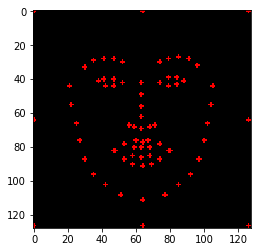

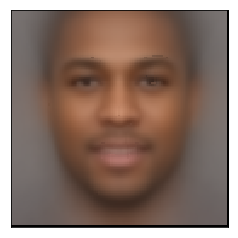

In [19]:
# img_paths = ['000026.jpg', '000040.jpg']
# img_dir = './data/'
img_dir = '/Users/azhong/face/data/celeba/Img/img_align_celeba/'
img_paths = race_gender_dict['african_male'][0:5000]
# img_paths = race_gender_dict['caucasian_female'][9:11]
final_w = 128
final_h = 128
# eye_corners_ref = [(np.float(0.3*final_w), np.float(final_h/3)), (np.float(0.7*final_w), np.float(final_h/3))]
eye_corners_ref = [(np.int(0.3*final_w), np.int(final_h/3)), (np.int(0.7*final_w), np.int(final_h/3))]
imagesNorm = []
pointsNorm = []

# boundary pts for delaunay triangulation
boundaryPts = np.array([(0,0), (final_w/2,0), (final_w-1,0), (final_w-1,final_h/2), 
                        ( final_w-1, final_h-1 ), ( final_w/2, final_h-1 ), (0, final_h-1), (0,final_h/2) ])
landmark_size = 68
pointsAvg = np.array([(0, 0)]*(landmark_size+8), np.float32())

numImages = 0
for img_path in img_paths:
    full_img_path = os.path.join(img_dir, img_path)
    bgr_image = cv2.imread(full_img_path)
#     bgr_image =  np.fliplr(bgr_image)
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
    rgb_image_vis = rgb_image.copy()
    gray_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2GRAY)
    face_rects = face_detector.detectMultiScale(gray_image, 1.3, 5)
    if len(face_rects) == 1:
        numImages+=1

for img_path in img_paths:
    full_img_path = os.path.join(img_dir, img_path)
    bgr_image = cv2.imread(full_img_path)
#     bgr_image =  np.fliplr(bgr_image)
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
    rgb_image_vis = rgb_image.copy()
    gray_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2GRAY)
    face_rects = face_detector.detectMultiScale(gray_image, 1.3, 5)
    if len(face_rects) == 1:
        face_rect = face_rects[0]
        x, y, w, h = face_rect
        extend_ratio = 0.2
        extend_w = int(w * extend_ratio/2)
        extend_h = int(h * extend_ratio/2)
        ymin = y-extend_h
        xmin = x-extend_w
        xmax = x+w+extend_w
        ymax = y+h+extend_h
        face_crop_bgr = extract_patch(bgr_image, xmin, ymin, xmax, ymax)
        face_crop_original_rgb = cv2.cvtColor(face_crop_bgr.copy(), cv2.COLOR_BGR2RGB)
        face_crop_original_rgb_vis = cv2.cvtColor(face_crop_bgr.copy(), cv2.COLOR_BGR2RGB)
        
        original_shape = face_crop_bgr.shape
        face_crop_bgr = cv2.resize(face_crop_bgr, (refined_landmark_target_size))
        face_crop_rgb_vis = cv2.cvtColor(face_crop_bgr.copy(), cv2.COLOR_BGR2RGB)
        face_crop_bgr_in = ((face_crop_bgr / 255.0) - 0.5) * 2
        face_crop_bgr_in = np.expand_dims(face_crop_bgr_in, 0)
        refined_landmark_prediction = refined_landmark_inference.run(face_crop_bgr_in)

        face_landmarks_original = []
        face_landmarks_raw = []
        for i in range(68):
            face_landmarks_original.append([refined_landmark_prediction[0][0][i*2]/refined_landmark_target_size[0]*original_shape[0], 
                                            refined_landmark_prediction[0][0][i*2+1]/refined_landmark_target_size[1]*original_shape[1]])
            face_landmarks_raw.append([int(refined_landmark_prediction[0][0][i*2]/refined_landmark_target_size[0]*(w+extend_w*2)+x-extend_w), 
                                       int(refined_landmark_prediction[0][0][i*2+1]/refined_landmark_target_size[1]*(h+extend_h*2)+y-extend_h)])
#             face_landmarks_raw.append([refined_landmark_prediction[0][0][i*2]/refined_landmark_target_size[0]*(w+extend_w*2)+x-extend_w, 
#                                        refined_landmark_prediction[0][0][i*2+1]/refined_landmark_target_size[1]*(h+extend_h*2)+y-extend_h])
            
            cv2.circle(face_crop_original_rgb_vis, (int(face_landmarks_original[-1][0]),
                                                    int(face_landmarks_original[-1][1])),
                       1, (255), -1)
                        
            cv2.circle(rgb_image_vis, (int(face_landmarks_raw[-1][0]),
                                                    int(face_landmarks_raw[-1][1])),
                       1, (255), -1)
                                    
            cv2.circle(face_crop_rgb_vis, (int(refined_landmark_prediction[0][0][i*2]),
                                           int(refined_landmark_prediction[0][0][i*2+1])),
                       1, (255), -1)
#         plt.imshow(face_crop_original_rgb_vis)
#         plt.title('landmarks original')
#         plt.show()
#         plt.imshow(rgb_image_vis)
#         plt.title('landmarks raw')
#         plt.show()
#         plt.imshow(face_crop_rgb_vis)
#         plt.title('landmarks inout')
#         plt.show()        
        eye_corners_src = [face_landmarks_raw[36], face_landmarks_raw[45]]
#         print(eye_corners_ref)
#         print(eye_corners_src)
        tform = similarityTransform(eye_corners_src, eye_corners_ref)
        img = cv2.warpAffine(rgb_image, tform, (final_w, final_h))
        points2 = np.reshape(np.array(face_landmarks_raw), (68, 1, 2))
        points = cv2.transform(points2, tform)
        points = np.float32(np.reshape(points, (68, 2)))
#         print('raw', face_landmarks_raw)
#         print('transformed', points)
        points = np.append(points, boundaryPts, axis=0)
        pointsAvg = pointsAvg + points/numImages
        pointsNorm.append(points)
        imagesNorm.append(img)
        
#         plt.imshow(img)
#         plt.title('norm')
#         plt.show()

rect = (0, 0, final_w, final_h)
img_null = np.zeros((final_h,final_w,3), np.float32());
for x, y in pointsAvg:
    cv2.circle(img_null, (int(x), int(y)), 1, (255, 0, 0), -1)
plt.imshow(img_null)
plt.show()

dt = calculateDelaunayTriangles(rect, np.array(pointsAvg))
# Output image
output = np.zeros((final_h,final_w,3), np.float32());

assert numImages == len(imagesNorm)
# Warp input images to average image landmarks
for i in range(0, len(imagesNorm)) :
    img = np.zeros((final_h,final_w,3), np.float32());
    # Transform triangles one by one
    for j in range(0, len(dt)) :
        tin = []; 
        tout = [];
#        img_null = np.zeros((final_h,final_w,3), np.float32());

        for k in range(0, 3) :                
            pIn = pointsNorm[i][dt[j][k]];
            pIn = constrainPoint(pIn, final_w, final_h);

            pOut = pointsAvg[dt[j][k]];
            pOut = constrainPoint(pOut, final_w, final_h);

            tin.append(pIn);
            tout.append(pOut);

        warpTriangle(imagesNorm[i], img, tin, tout);
#        warpTriangle(imagesNorm[i], img_null, tin, tout);
#         plt.imshow(img_null/255.0)
#         plt.title('{}, {}'.format(i, j))
#         plt.show()


    # Add image intensities for averaging
    output = output + img;
#     plt.imshow(output/(i+1)/255.0)
#     plt.title('{}'.format(i))
#     plt.show()


# Divide by numImages to get average

output = output / numImages;
# Display result
plt.imshow(output/255.0)
plt.xticks([])
plt.yticks([])

plt.show()


In [10]:
import pickle
header_lines = pickle.load(open('/Users/azhong/face/face_attrib/celeba_header_lines_45.p', 'rb'))
lines = header_lines['lines']
header = header_lines['header']
race_indices = [1, 2, 3, 4, 5]
gender_index = 26
race_gender_dict = {}
for line in lines:
    for race_index in race_indices:
        if line[race_index] == 1:
            key_name = header[race_index]
            if line[gender_index] == 1:
                key_name += '_male'
            else:
                key_name += '_female'
            if key_name not in race_gender_dict:
                race_gender_dict[key_name] = []
            race_gender_dict[key_name].append(line[0])

In [9]:
len(race_gender_dict['caucasian_female'])

96882